In [414]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
warnings.filterwarnings("ignore")

In [415]:
df = pd.read_csv("./max_data/max_dataset.csv")
df = df.fillna("Nil")
df.replace("0", "Nil", inplace=True)
df.replace("Nil", 0, inplace=True)
df.replace("Negative", 0, inplace=True)
df.replace("Normal", 0, inplace=True)
df.replace("Absent", 0, inplace=True)
df.replace("Yes", True, inplace=True)
df.replace("No", False, inplace=True)
df.replace("yes", True, inplace=True)
df.replace("no", False, inplace=True)
df.replace("True", True, inplace=True)
df.replace("False", False, inplace=True)
df = df.select_dtypes(include=[int, float, bool, object])
df = df.drop(columns=[df.columns[0], df.columns[1]])
df

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1-Jan-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,8-Feb-1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,7-Aug-1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1-Feb-1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7-May-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,6-Feb-1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,31-Oct-1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,25-Jul-1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [416]:
# print the type of each column in the df
types = [df[col].dtype for col in df.columns]

# print value counts of types
print("Value counts of types:")
print(pd.Series(types).value_counts())

Value counts of types:
object     352
int64      110
bool        93
float64     74
Name: count, dtype: int64


In [417]:
def support_count(df, r):
    return ((df.iloc[r] != 0) & (df.iloc[r] != 0.0) & (df.iloc[r] != False)).sum()

In [418]:
def support_columns(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].columns

In [419]:
def support(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index]

In [420]:
def support_values(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].iloc[r]

In [421]:
def support_count_c(df, c):
    return ((df.loc[:, c] != 0) & (df.loc[:, c] != 0.0) & (df.loc[:, c] != False)).sum()

In [422]:
def union_support_count(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return len(list(set(columns1) | set(columns2)))

In [423]:
def union_support_columns(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return list(set(columns1) | set(columns2))

In [424]:
# Sim(ri1, ri2) as defined by the paper
def similar(ri1, ri2):
    if type(ri1) != type(ri2):
        return 0
    elif (type(ri1) is np.int64 and type(ri2) is np.int64) or (type(ri1) is int and type(ri2) is int):
        return 1 if ri1 == ri2 else 0
    elif (type(ri1) is np.float64 and type(ri2) is np.float64) or (type(ri1) is float and type(ri2) is float):
        return 1 if math.isclose(ri1, ri2, rel_tol=1e-9) else 0
    elif (type(ri1) is bool and type(ri2) is bool) or (type(ri1) is np.bool_ and type(ri2) is np.bool_):
        return 1 if ri1 == ri2 else 0
    elif type(ri1) is str and type(ri2) is str:
        return 1 if ri1 == ri2 else 0
    else:
        print(f"Uncaught, {type(ri1)}, {type(ri2)}")
        return 0

In [425]:
# Sim(r1, r2) as defined by the paper
def compute_similarity(df, r1, r2):
    
    similarity = 0
    for column in union_support_columns(df, r1, r2):
        similarity += similar(df.loc[r1, column], df.loc[r2, column])
    
    sim_score = similarity/union_support_count(df, r1, r2) if union_support_count(df, r1, r2) != 0 else 0
    return sim_score

In [426]:
# For the adversary's information, Aux(r). This randomly selects the columns that they know about
# We can consider a different method as well, based on some information measure, for eg some entropy measure or the number of rows that each column has a valid value for
def auxillary_columns(df, r, count):
    
    aux = random.sample(list(support_columns(df, r)), min(count, support_count(df, r)))
    return aux

In [427]:
# Aux(r) as defined by the paper
def auxillary(df, r, count):
    
    aux = df.loc[r, auxillary_columns(df, r, count)]
    return aux

In [428]:
# Score(aux, r') as defined by the paper
def score(df, aux, r0):
    
    score = 0
    for column in aux.index:
        if column in support_columns(df, r0):
            score += similar(aux.loc[column], df.loc[r0, column])
    
    return score/len(aux.index) if len(aux.index) != 0 else 0

In [429]:
# Robust Score(aux, r') as defined by the paper
def score_robust(df, aux, r0):
    
    score = 0
    for column in aux.index:
        if column in support_columns(df, r0):
            score += (similar(aux.loc[column], df.loc[r0, column])/math.log(support_count_c(df, column)))
    
    return score/len(aux.index) if len(aux.index) != 0 else 0

In [430]:
# Best guess as defined by the paper
def best_guess(candidates, eccentricity):
    sorted_candidates = candidates.sort_values(ascending=False)
    heuristic = (sorted_candidates.index[0] - sorted_candidates.index[1])/candidates.std()
    return sorted_candidates.index[0] if heuristic >= eccentricity else None

In [431]:
# Matching criterion as defined by the paper
def match(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score(df, aux, row))
    candidates = candidates[candidates >= alpha]
    if candidates.empty:
        return pd.Series({"-1": 0})
    return candidates

In [432]:
# Robust matching criterion as defined by the paper
def match_robust(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score(df, aux, row))
    candidates = candidates[candidates >= alpha]
    if candidates.empty:
        return pd.Series({"-1": 0})
    elif candidates.shape[0] > 1:
        return best_guess(candidates, 1.5)
    return candidates

In [433]:
# Scoreboard() as defined by the paper
def scoreboard(df, count):
    
    scores = pd.DataFrame(index=df.index, columns=df.index)
    for r1 in tqdm(list(df.index)[:200]):
        aux = auxillary(df, r1, count)
        for r2 in list(df.index)[:200]:
            scores.loc[r1, r2] = score(df, aux, r2)
            
    return scores

In [434]:
# Scoreboard-RH from paper
def compute_score(df, r1):
    supported = df.loc[r1, support_cols(r1)]
    print(supported)
    aux = [supported.index[i] for i in [random.randint(0, len(supported)) for _ in range(4)]]
    print(aux)
    weight = 1/(math.log(support(r1)))
    print(weight)

    df["scores"] = df.apply(lambda row2: (sum(similar(supported, r1, row2, column))) for column in df.loc[:, aux].columns)
    print(df["scores"].head())
    df["scores"] = weight * df["scores"]
    print(df["scores"].head())
    score = df["scores"].max()
    print(score)
    score2 = df["scores"].nlargest(2)

    return score, score2, df["scores"].std()

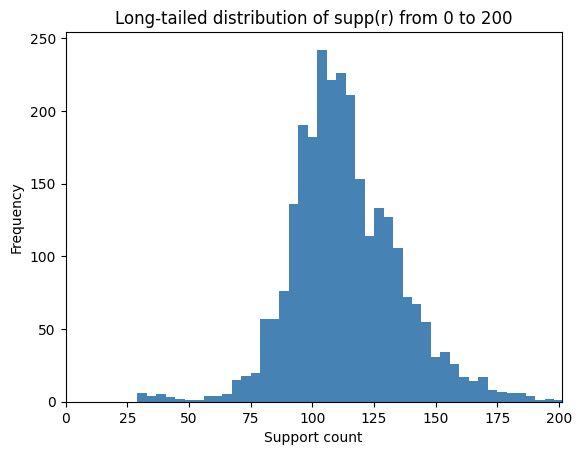

In [435]:
support_counts = pd.Series(df.index).apply(lambda x: support_count(df, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r) from 0 to 200", xlim=(0, 201), xlabel="Support count", ylabel="Frequency")
plt.show()

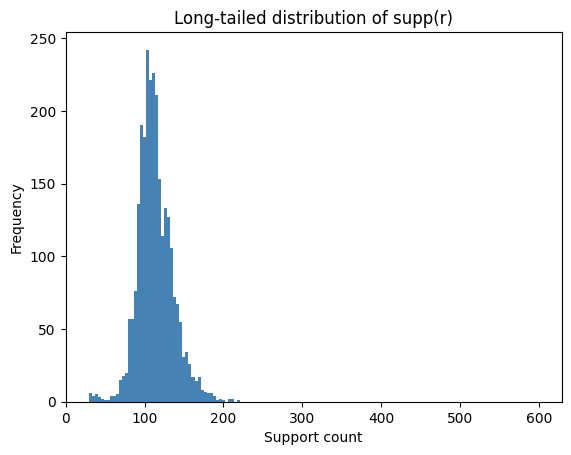

In [436]:
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r)", xlim=(0, len(df.columns)), xlabel="Support count", ylabel="Frequency")
plt.show()

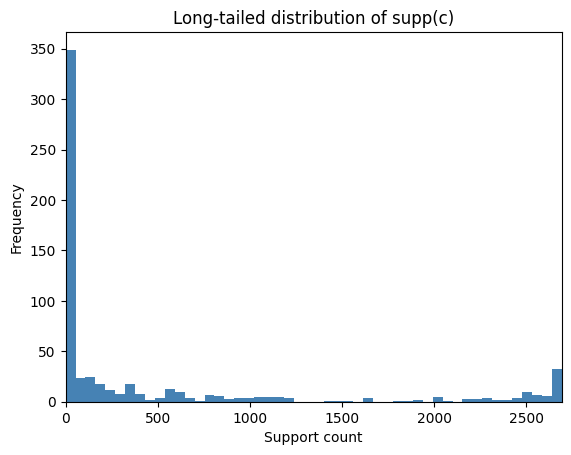

In [437]:
support_counts = pd.Series(df.columns).apply(lambda x: support_count_c(df, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(c)", xlim=(0, len(df)), xlabel="Support count", ylabel="Frequency")
plt.show()

In [438]:
df3 = df[[col for col in df.columns]]
df3

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1-Jan-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,8-Feb-1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,7-Aug-1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1-Feb-1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7-May-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,6-Feb-1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,31-Oct-1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,25-Jul-1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [439]:
similar(df3.iloc[0, 1], df3.iloc[3, 1])

1

In [440]:
compute_similarity(df3, 0, 3)

0.23076923076923078

In [ ]:
nn = pd.Series(df3.index).progress_apply(lambda x: max([compute_similarity(df3, x, i) for i in df3.index if i != x]))

  1%|          | 30/2692 [35:14<48:10:29, 65.15s/it]

In [ ]:
nn.head()
nn.to_csv("./nearestneighbours.csv")

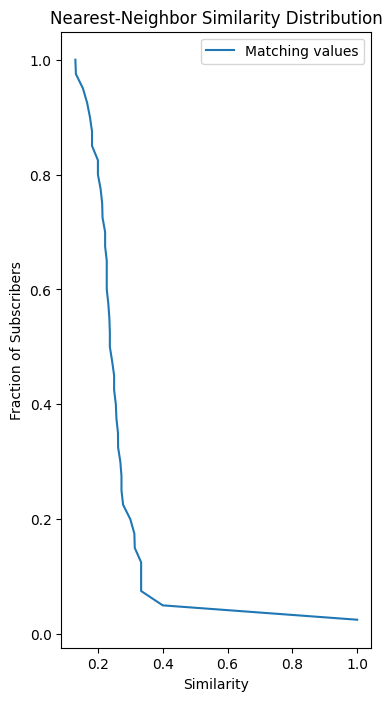

In [ ]:
sorted_nn = nn.reset_index().sort_values(by=0, ascending=False)
fractions = np.arange(1, len(sorted_nn) + 1) / len(sorted_nn)

plt.figure(figsize=(4, 8))
plt.plot(sorted_nn[0].values, fractions, marker='', label='Matching values')
plt.xlabel("Similarity")
plt.ylabel("Fraction of Subscribers")
plt.title("Nearest-Neighbor Similarity Distribution")
plt.legend(fontsize=10)
plt.show()

In [ ]:
auxillary(df3, 54, 4)

LSRC.stoolroutineandmicroscopy_colour           Brown
LSRT.consistency                                 Soft
EGLY.lymphadenopathy                     Not Palpable
Name: 54, dtype: object

In [ ]:
score(df3, auxillary(df3, 54, 4), 0)

0.3333333333333333

In [ ]:
match(df3, auxillary(df3, 2, 10), 0.5)

-1    0
dtype: int64

In [ ]:
match(df3, auxillary(df3, 3, 10), 0.5)

3       1.0
199     0.5
1587    0.5
dtype: float64

In [ ]:
results200x12 = scoreboard(df3, 12)

100%|██████████| 200/200 [13:13<00:00,  3.97s/it]


In [ ]:
results200x12.to_csv("./resultscount12.csv")
results200x12.loc[:199, :199]

,0,1,2,3,4,5,6,7,8,9,...,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691
0,1.0,0.0,0.166667,0.25,0.333333,0.0,0.0,0.083333,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,1.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.166667,0.0,1.0,0.25,0.25,0.0,0.25,0.166667,0.0,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.166667,0.0,0.5,1.0,0.166667,0.0,0.083333,0.083333,0.0,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.333333,0.0,0.333333,0.166667,1.0,0.0,0.166667,0.166667,0.0,0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.166667,0.0,0.25,0.0,0.166667,0.0,0.0,0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0.0,0.0,0.25,0.083333,0.083333,0.083333,0.416667,0.166667,0.0,0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

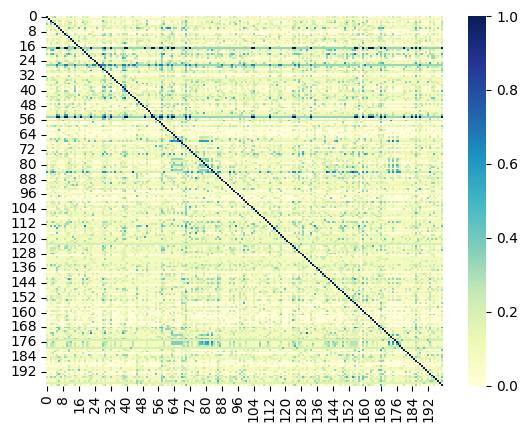

In [ ]:
sns.heatmap(results200x12.iloc[:200, :200].astype(float), annot=False, cmap="YlGnBu", linewidths=0) # count=12, alpha=0.5

<Axes: >

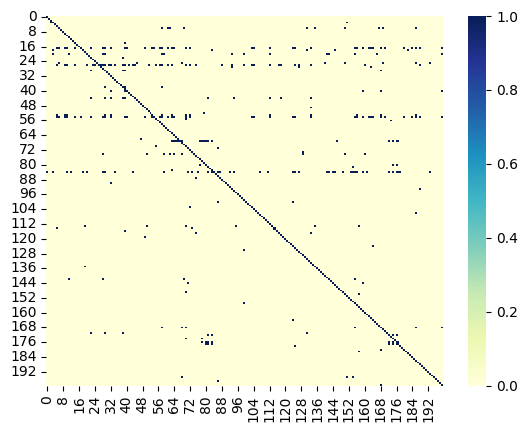

In [ ]:
# same heatmap as above but with only two colours, showing value >= 0.5 or not
sns.heatmap(results200x12.iloc[:200, :200].astype(float) >= 0.5, annot=False, cmap="YlGnBu", linewidths=0) # count=12, alpha=0.5

<Axes: >

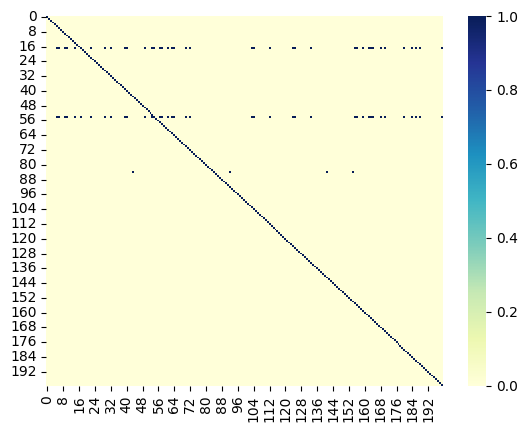

In [ ]:
sns.heatmap(results200x12.iloc[:200, :200].astype(float) >= 0.75, annot=False, cmap="YlGnBu", linewidths=0) # count=12, alpha=0.75

In [ ]:
cop = results200x12.copy()
results2 = cop.progress_apply(lambda col: col.index.to_series().apply(lambda row_idx: union_support_count(df3, row_idx, col.name)))

100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


In [ ]:
results2.to_csv("./results2.csv")
results2.iloc[:200, :200]

<Axes: >

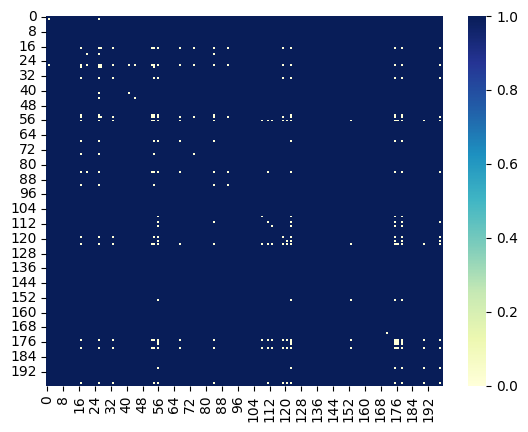

In [ ]:
sns.heatmap(results2.iloc[:200, :200].astype(float) >= 12, annot=False, cmap="YlGnBu", linewidths=0) # count=100